In [9]:
import os, sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import yaml

In [10]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)

Make sure that the following packages are **pip**-installed. 

In [11]:
from classy import Class
from iminuit import minimize as minuit
import emcee
from getdist import loadMCSamples, plots, mcsamples, MCSamples

Calling the `likelihood` class of **PyBird**

In [12]:
from pybird.likelihood import Likelihood

# EFT likelihood of BOSS

### Setting up the likelihood

First, let us create a CLASS engine M, that will be provided to the likelihood. 

In [13]:
M = Class()
cosmo = {'omega_b': 0.02235, 'omega_cdm': 0.120, 'h': 0.675, 'ln10^{10}A_s': 3.044, 'n_s': 0.965}
M.set(cosmo)
M.set({'output': 'mPk', 'P_k_max_h/Mpc': 10, 'z_max_pk': 1})
M.compute()

Next, let us setup the EFT likelihood of the power spectrum multipoles of BOSS CMASS NGC.

We first load the relevant config file. 

In [14]:
rootdir = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'pybird')
configdir = os.path.join(rootdir, 'data', 'eftboss', 'config')

In [15]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_pk_wc.yaml'), 'r'))
config["data_path"] = os.path.join(rootdir, config["data_path"])
config["write"]["out_path"] = os.path.join(rootdir, config["write"]["out_path"])
print ( yaml.dump(config, indent=4, sort_keys=False))

data_path: /Users/pierre/Documents/github/pybird/data/eftboss/
data_file: boss_dr12_2pt.h5
output: bPk
multipole: 2
with_ap: true
with_survey_mask: true
sky:
    cmass_ngc:
        min:
        - 0.01
        - 0.01
        max:
        - 0.23
        - 0.23
write:
    save: true
    fake: false
    plot: true
    show: true
    out_path: /Users/pierre/Documents/github/pybird/data/eftboss/out/
    out_name: boss_onesky_pk_wc
km: 0.7
kr: 0.35
nd: 0.0004
eft_basis: westcoast
with_stoch: true
eft_prior:
    b1:
        type: flat
        range: null
    c2:
        type: gauss
        mean:
        - 0.0
        range:
        - 2.0
    c4:
        type: unvaried
    b3:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cct:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cr1:
        type: marg_gauss
        mean:
        - 0.0
        range:
        - 2.0
    cr2:
        type: marg_gauss
        mean:
        - 0

As we can see, there is a bunch of options there. Most should be self-explanatory. We can see that we can specify  the data, the output, the multipoles, the ranges (min / max) per multipoles, corrections to observational effects, and the prior, to include in the analysis. Useful configuration examples can be found in [this data folder](../data/eftboss/config/). 

There are basically three types of prior: `flat` (no prior), `gauss` (with mean and range to specify), and `marg_gauss`, which is also a Gaussian prior but with the parameter, because appearing at most quadratically in the likelihood, analytically marginalized. 

Let us setup the likelihood with this configuration. 

In [16]:
L = Likelihood(config)

-----------------------
sky: cmass_ngc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.23, 0.23]
coordinate (AP) distortion: on
survey mask: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 40 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


Now let us evaluate the likelihood on the cosmology given through the CLASS engine M.

As this is the first time we evaluate the likelihood on this cosmology, we specify it through the flat "need_cosmo_update" such that the likelihood calls PyBird to compute the predictions. As such, this evaluation may take a few seconds. 

In [17]:
eft_name = ['b1', 'c2'] 
eft_init = [2, 0] 
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

As we can see, the structure of the log-likelihood function is very simple: one needs to provide the values of the EFT parameters that are scanned, the corresponding names, the CLASS engine, and the `need_cosmo_update` flag. 

In particular, we provide [here](../montepython/) an integration in **[MontePython](https://github.com/brinckmann/montepython_public)**.

### Maximizing the likelihood

Now that the PyBird predictions are computed, we can scan over the EFT parameters in almost no time if we do not update the cosmology. 

Let us maximize the likelihood with respect to the EFT parameters! We use **[iminuit](https://iminuit.readthedocs.io/)**.

Notice that we do not explicitly need to scan over most of the EFT parameters except a few, as most of them can be analytically marginalized over with a Gaussian prior. Importantly, when searching for the most-likely value, we do maximize, within priors, the global likelihood, and not the marginalized one (see App. C of [2003.07956](https://arxiv.org/abs/2003.07956)). 

In [18]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))
with np.printoptions(precision=3): print ('bestfit %s: %s' % (eft_name, minimum['x']))

min chi2: 31.81, p-value: 0.476
bestfit ['b1', 'c2']: [1.954 0.59 ]


The following function generates with the previously obtained best fit data files and plots if specified so in the config file under the option "write". 

data files with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.


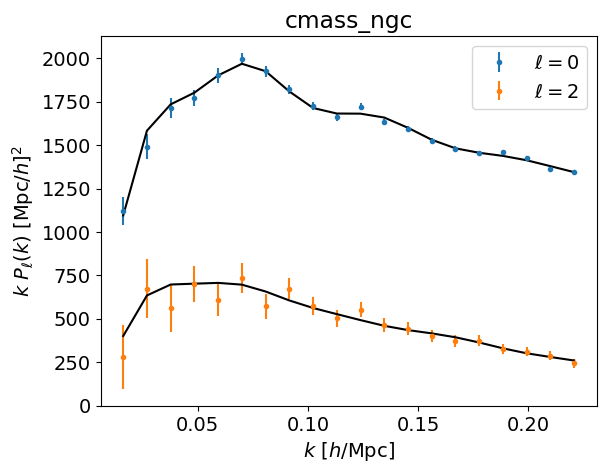

In [19]:
L.write()

### Sampling from the likelihood

Let us now sample the posteriors of the EFT parameters from the likelihood. We use **[emcee](https://emcee.readthedocs.io/)**.

In [20]:
L.c["get_maxlkl"] = False # marginalization mode

pos = minimum['x'] + 1e-4 * np.random.randn(len(eft_name)*4, len(eft_name))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, L.loglkl, args=(eft_name, M, False))
sampler.run_mcmc(pos, 5000, progress=True);

tau = np.array(sampler.get_autocorr_time())
with np.printoptions(precision=0): print(tau)

flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)
print(flat_samples.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:44<00:00, 112.38it/s]

[44. 50.]
(1600, 2)


Removed no burn in


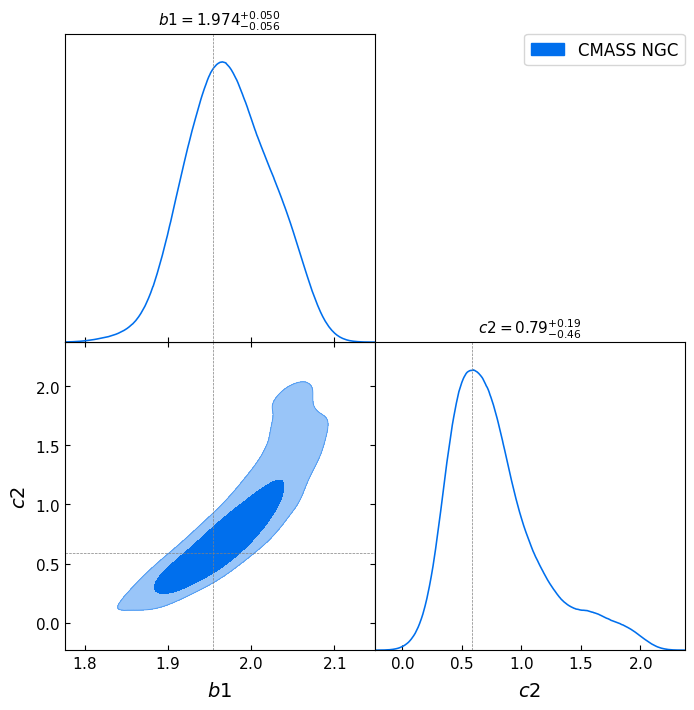

In [21]:
samples = MCSamples(samples=flat_samples, names = eft_name, labels = eft_name)
g = plots.get_subplot_plotter(width_inch=8) 
g.triangle_plot(samples, eft_name, filled=True, markers=minimum['x'], title_limit=1, 
                legend_labels=['CMASS NGC'])
plt.show()

### Comparing $P_\ell(k)$ vs. $\xi_\ell(s)$

Cool. Now, let us do the same with the multipoles of the correlation function of BOSS CMASS NGC and compare!

In [22]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_cf_wc.yaml'), 'r'))
config["data_path"] = os.path.join(rootdir, config["data_path"])
L = Likelihood(config)

-----------------------
sky: cmass_ngc
output: bCf
multipole: 2
min bound (per multipole): [20, 20]
max bound (per multipole): [200, 200]
coordinate (AP) distortion: on
binning: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 72 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


In [23]:
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

In [24]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))
with np.printoptions(precision=3): print ('bestfit %s: %s' % (eft_name, minimum['x']))

min chi2: 70.16, p-value: 0.340
bestfit ['b1', 'c2']: [1.939 0.603]


In [25]:
L.c["get_maxlkl"] = False # marginalization mode

pos = minimum['x'] + 1e-4 * np.random.randn(len(eft_name)*4, len(eft_name))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, L.loglkl, args=(eft_name, M, False))
sampler.run_mcmc(pos, 5000, progress=True);

tau = np.array(sampler.get_autocorr_time())
with np.printoptions(precision=0): print(tau)

flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)
print(flat_samples.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.20it/s]

[41. 44.]
(1600, 2)


Removed no burn in


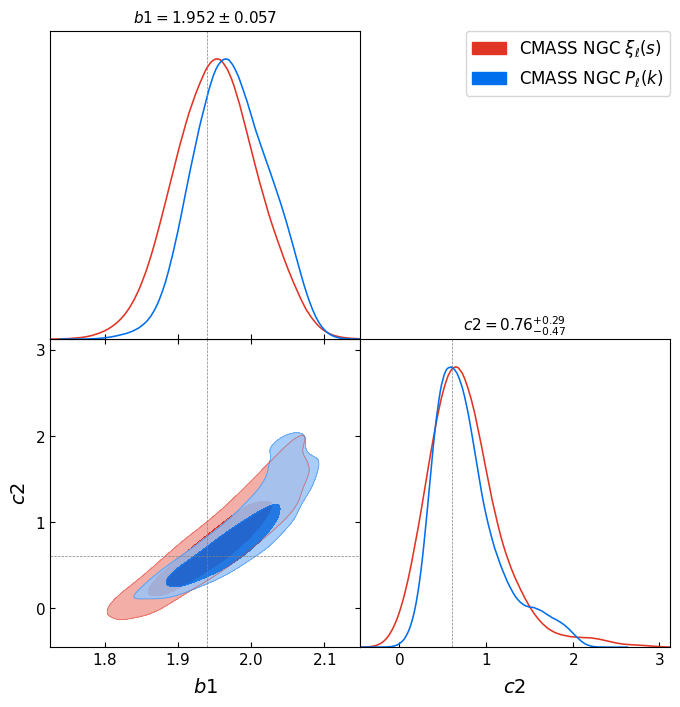

In [26]:
samples_cf = MCSamples(samples=flat_samples, names = eft_name, labels = eft_name)
g = plots.get_subplot_plotter(width_inch=8) 
g.triangle_plot([samples_cf, samples], eft_name, filled=True, markers=minimum['x'], title_limit=1, 
                legend_labels=[r'CMASS NGC $\xi_\ell(s)$', r'CMASS NGC $P_\ell(k)$'])
plt.show()

### Comparing EFT priors

Cool. What happens if we analyze the power spectrum but with another prior, say the East-Coast prior (see e.g., [2208.05929](https://arxiv.org/abs/2208.05929))?

In [27]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_cmass_ngc_pk_ec.yaml'), 'r'))
config["data_path"] = os.path.join(rootdir, config["data_path"])
L = Likelihood(config)

-----------------------
sky: cmass_ngc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.23, 0.23]
coordinate (AP) distortion: on
survey mask: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 40 bins
-----------------------
get_maxlkl : False
with_boss_correlated_skies_prior : False
with_rs_marg : False
-----------------------


In [28]:
eft_name_ec = ['b1', 'bt2', 'bG2'] 
eft_init_ec = [2., 0., 0.]
init = L.loglkl(eft_init_ec, eft_name_ec, M, need_cosmo_update=True)

In [29]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name_ec, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init_ec)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name_ec) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))
with np.printoptions(precision=3): print ('bestfit %s: %s' % (eft_name_ec, minimum['x']))

min chi2: 34.05, p-value: 0.238
bestfit ['b1', 'bt2', 'bG2']: [ 1.992 -1.29  -0.071]


In [30]:
L.c["get_maxlkl"] = False # marginalization mode

pos = minimum['x'] + 1e-4 * np.random.randn(len(eft_name_ec)*4, len(eft_name_ec))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, L.loglkl, args=(eft_name_ec, M, False))
sampler.run_mcmc(pos, 5000, progress=True);

tau = np.array(sampler.get_autocorr_time())
with np.printoptions(precision=0): print(tau)

flat_samples = sampler.get_chain(discard=1000, thin=20, flat=True)
print(flat_samples.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:20<00:00, 62.01it/s]


[39. 41. 48.]
(2400, 3)


Removed no burn in


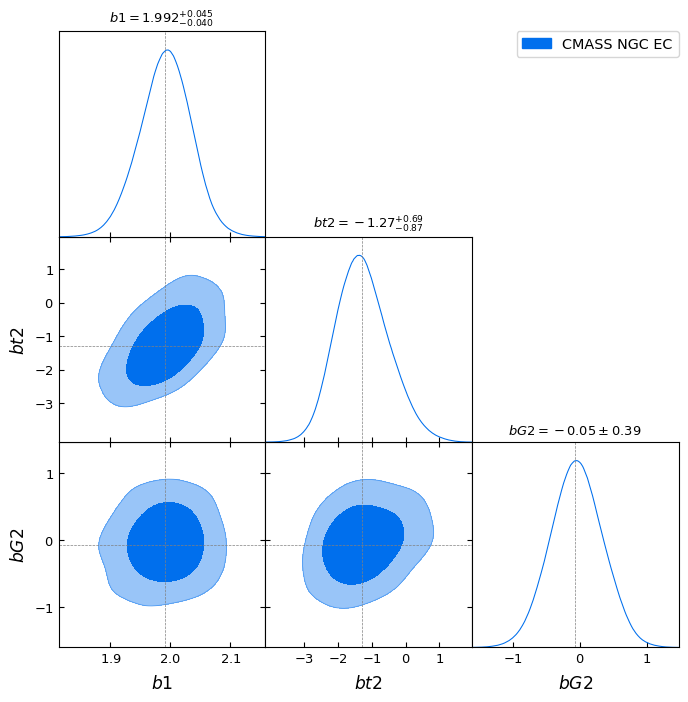

In [31]:
samples_ec = MCSamples(samples=flat_samples, names = eft_name_ec, labels = eft_name_ec)
g = plots.get_subplot_plotter(width_inch=8) 
g.triangle_plot(samples_ec, eft_name_ec, filled=True, markers=minimum['x'], title_limit=1, 
                legend_labels=[r'CMASS NGC EC'])
plt.show()

### BOSS 4 skies

OK. If we have ~0.5 hour, we might as well do all four BOSS skies. 

In [32]:
config = yaml.full_load(open(os.path.join(configdir, 'boss_pk_wc.yaml'), 'r'))
config["data_path"] = os.path.join(rootdir, config["data_path"])
config["write"]["out_path"] = os.path.join(rootdir, config["write"]["out_path"])
L = Likelihood(config)

-----------------------
sky: cmass_ngc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.23, 0.23]
bao rec: on
coordinate (AP) distortion: on
survey mask: on
-----------------------
-----------------------
sky: cmass_sgc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.23, 0.23]
bao rec: on
coordinate (AP) distortion: on
survey mask: on
-----------------------
-----------------------
sky: lowz_ngc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.2, 0.2]
bao rec: on
coordinate (AP) distortion: on
survey mask: on
-----------------------
-----------------------
sky: lowz_sgc
output: bPk
multipole: 2
min bound (per multipole): [0.01, 0.01]
max bound (per multipole): [0.2, 0.2]
bao rec: on
coordinate (AP) distortion: on
survey mask: on
-----------------------
cmass_ngc: Hartlap factor correction on precision matrix estimated from 2048 mocks for 42 bins
cma

In [33]:
eft_name = []
for i in range(1,5): eft_name += ['b1_%s' % i, 'c2_%s' % i] 
eft_init = 4 * [2., 0.]
init = L.loglkl(eft_init, eft_name, M, need_cosmo_update=True)

In [34]:
L.c["get_maxlkl"] = True # minimization mode

def chi2(eft_params): return -2. * L.loglkl(eft_params, eft_name, M, need_cosmo_update=False)
minimum = minuit(chi2, eft_init)

from scipy import stats
def pvalue(minchi2, dof): return 1. - stats.chi2.cdf(minchi2, dof)
dof = L.y_all.shape[0] - len(eft_name) - L.Ng # number of data points - EFT parameters
print ('min chi2: %.2f, p-value: %.3f' % (minimum['fun'], pvalue(minimum['fun'], dof)))
with np.printoptions(precision=3): print ('bestfit %s: %s' % (eft_name, minimum['x']))

min chi2: 141.61, p-value: 0.587
bestfit ['b1_1', 'c2_1', 'b1_2', 'c2_2', 'b1_3', 'c2_3', 'b1_4', 'c2_4']: [1.954 0.59  2.047 1.187 1.906 1.114 1.881 1.114]


data files with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.


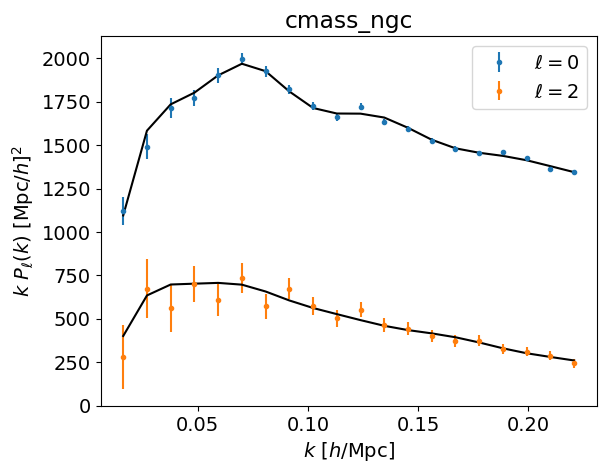

data files with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.


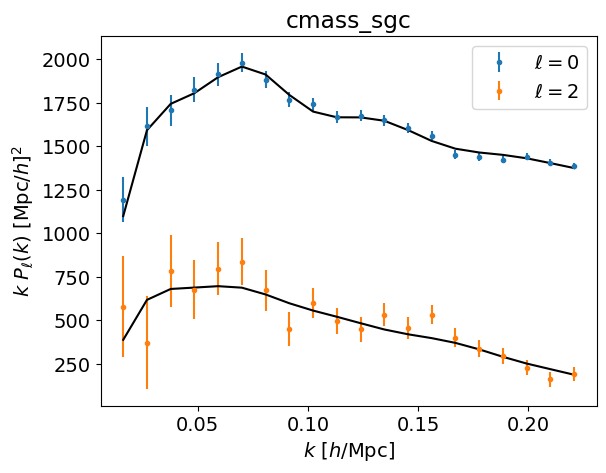

data files with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.


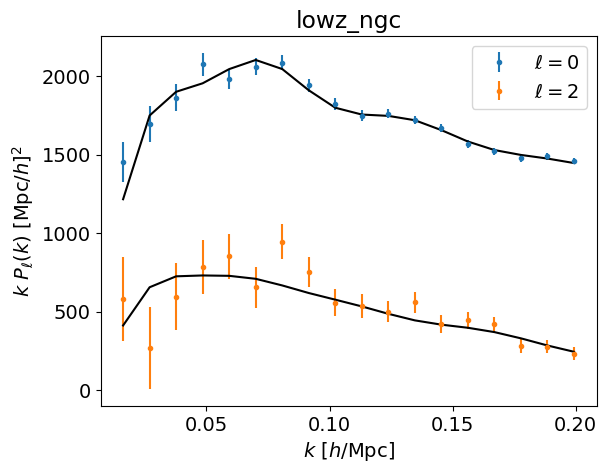

data files with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.
data plot with best fit saved to /Users/pierre/Documents/github/pybird/data/eftboss/out/.


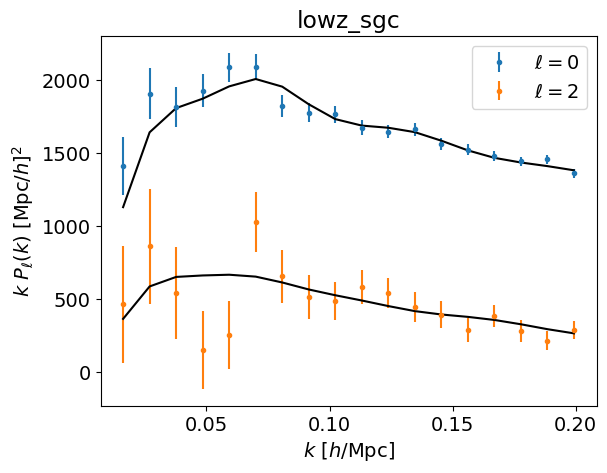

In [35]:
L.write()

In [36]:
L.c["get_maxlkl"] = False # marginalization mode

pos = minimum['x'] + 1e-4 * np.random.randn(len(eft_name)*3, len(eft_name))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, L.loglkl, args=(eft_name, M, False))
sampler.run_mcmc(pos, 20000, progress=True);

tau = np.array(sampler.get_autocorr_time())
with np.printoptions(precision=0): print(tau)

flat_samples = sampler.get_chain(discard=1000, thin=100, flat=True)
print(flat_samples.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [22:52<00:00, 14.57it/s]


[147. 180. 129. 128. 133. 140. 126. 139.]
(4560, 8)


Removed no burn in


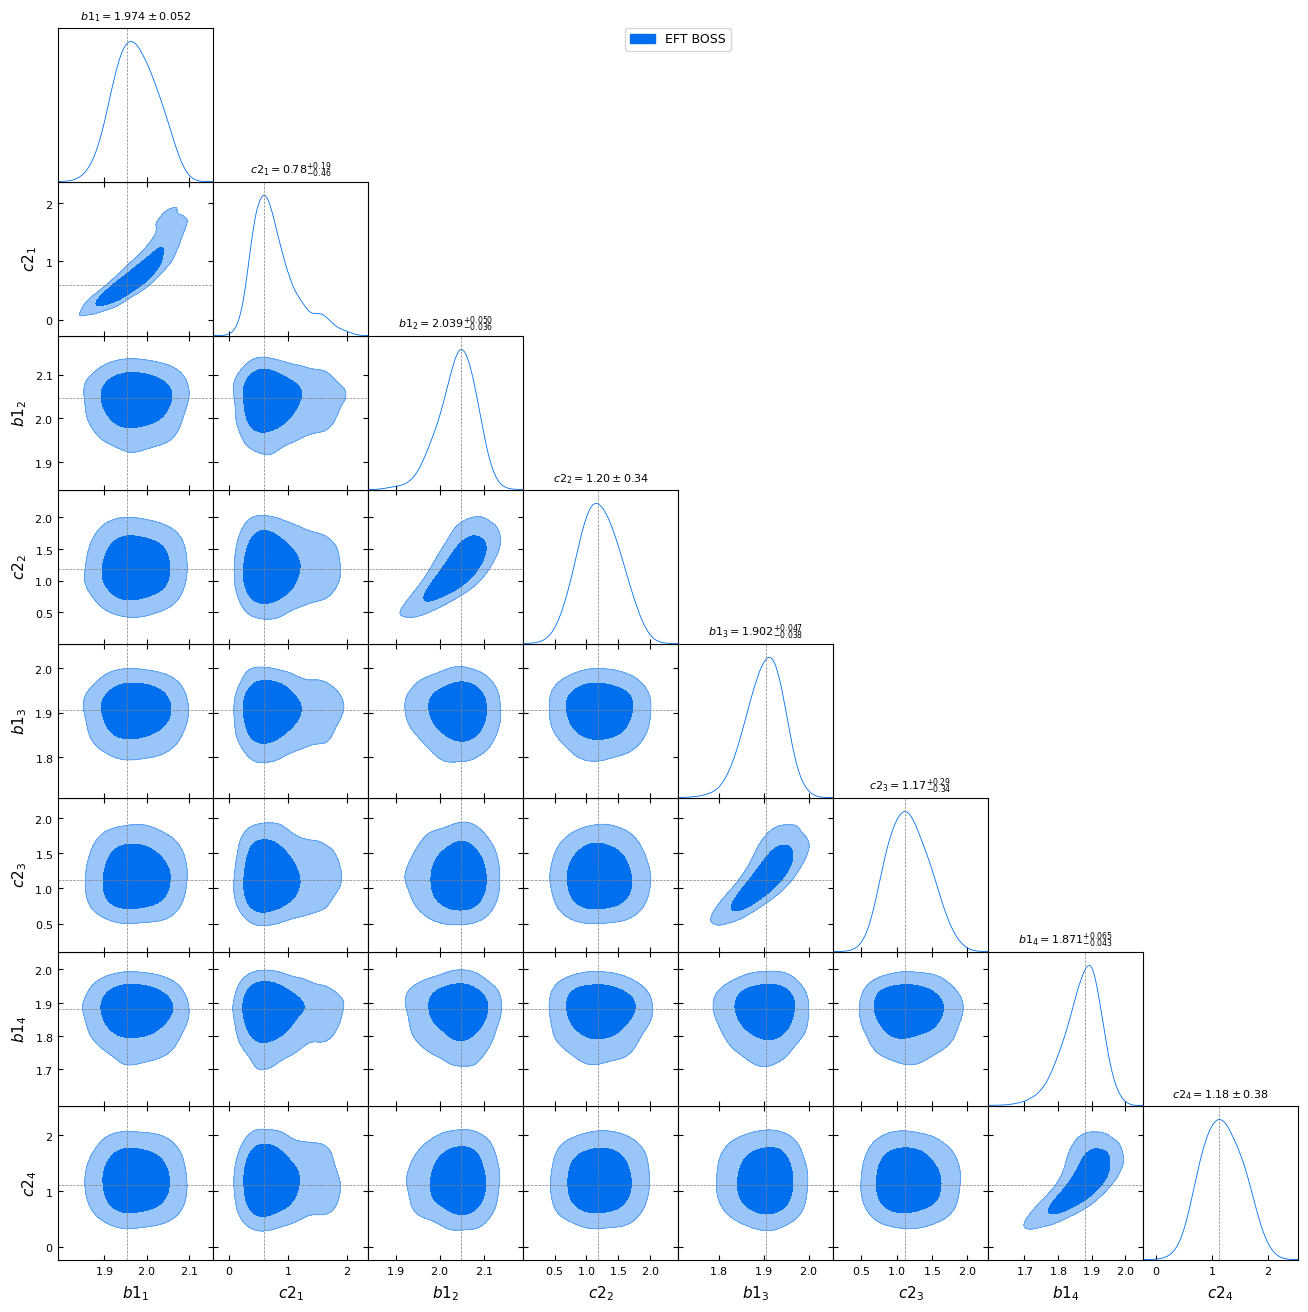

In [37]:
samples_boss = MCSamples(samples=flat_samples, names = eft_name, labels = eft_name)
g = plots.get_subplot_plotter(width_inch=16) 
g.triangle_plot(samples_boss, eft_name, filled=True, markers=minimum['x'], title_limit=1, 
                legend_labels=[r'EFT BOSS'])
plt.show()